In [1]:
import sys
from YoloSamPipeline import YoloSam

/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/ft_mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with ft_mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/ft_mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with ft_mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/ft_mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with ft_mobile_sam.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an existing na

In [5]:
yolo_path = './yolov8-segm-ft_no_stars-n-iter1/yolov8n-seg/weights/best.pt'
# efficient_vit_enc = '/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/MobileSAMv2/weight/l2.pt'

yolo_sam_pipeline = YoloSam(
    device='cuda:1', 
    yolo_checkpoint=yolo_path, 
    sam_checkpoint="./output_sam/ft_mobile_sam_final_2024-04-27 00:02:11.627528_last.pth", # the checkpoint and model_type (vit_h, vit_t, etc.) must be compatible
    model_type='vit_t',
    efficient_vit_enc=None,
    yolo_conf=0.3)

/opt/conda/envs/env_py311/lib/python3.11/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Number of object detected: 5
Iou predictions: tensor([0.9302, 0.8718, 0.8464, 0.8397, 0.8226])
Unique classes detected: 2
   smoke-ring

   star-loop

self.sam_predictor.input_size (1024, 1024)
Inference time: 0:00:03.991852


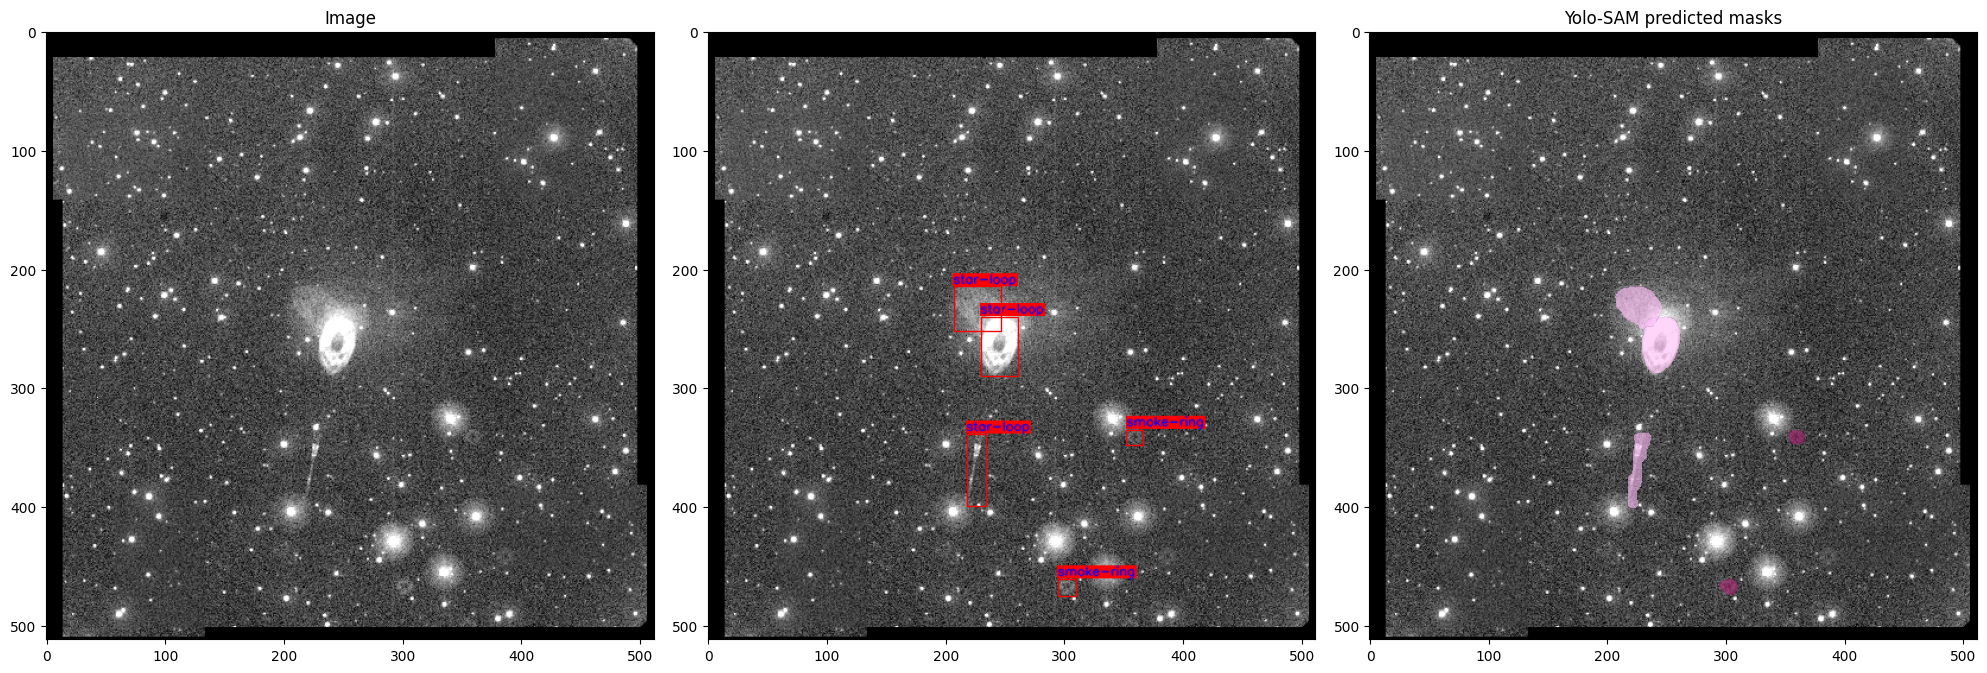

In [3]:
masks = yolo_sam_pipeline.run_predict('../XMM_OM_dataset/zscaled_512_stretched/S0782961401_L.png') 

Number of object detected: 27
Iou predictions: tensor([0.9222, 0.8428, 0.8597, 0.8740, 0.9297, 0.8788, 0.7945, 0.7880, 0.8647, 0.9823, 0.8579, 0.8609, 0.9636, 0.9570, 0.8195, 0.9113, 0.7465, 0.8058, 0.9515, 0.7355, 0.9503, 0.9696, 0.9530, 0.9345, 0.8524, 0.9680, 0.8588])
Unique classes detected: 4
   central-ring

   read-out-streak

   smoke-ring

   star-loop

self.sam_predictor.input_size (1024, 1024)
Inference time: 0:00:00.228117


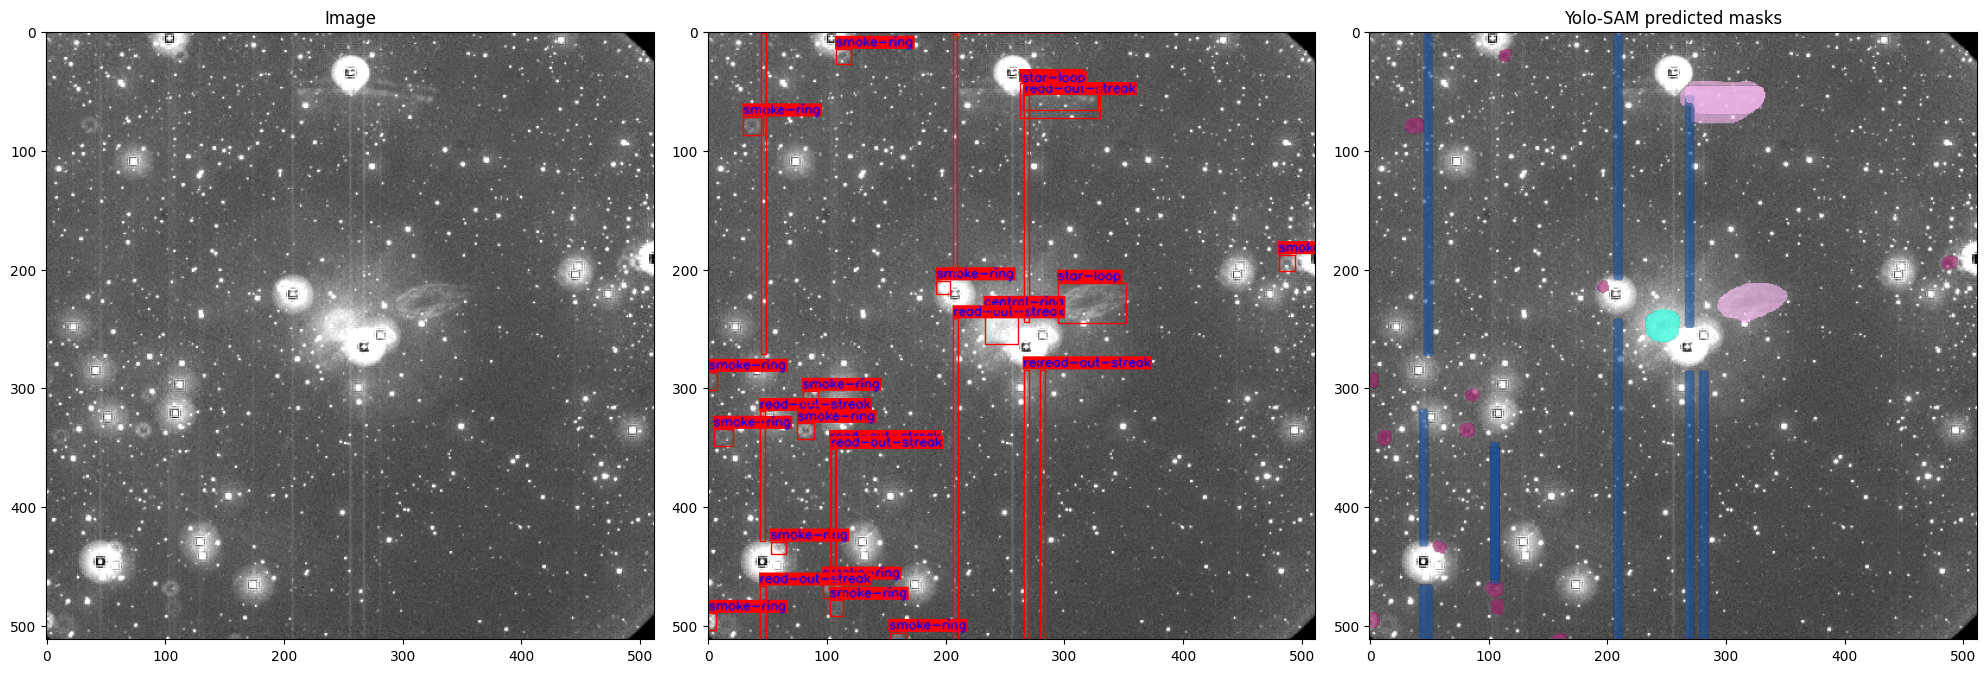

In [4]:
masks = yolo_sam_pipeline.run_predict('../XMM_OM_dataset/zscaled_512_stretched/S0504550601_U.png') 
# masks = yolo_sam_pipeline.run_predict('./Euclid-Grism-mode-caption1-768x768.png') 

In [5]:
import glob
from roboflow import Roboflow
from dataset import dataset_utils, voc_annotate_and_Roboflow_export

def export_image_det_to_Roboflow(input_dir, filename, masks, obj_results):
    class_names = obj_results[0].names
    class_labels = obj_results[0].boxes.data[:, -1].int().tolist()
    
    objects = []
    for i in range(len(masks)):
        # masks[i]: [ 1, H, W]
        mask_np = masks[i].detach().cpu().numpy()
        polygon = voc_annotate_and_Roboflow_export.binary_image_to_polygon(mask_np[0])
        bbox = dataset_utils.mask_to_bbox(mask_np)
        if class_names[class_labels[i]] != 'read-out-streak':
            objects.append({
                'name': class_names[class_labels[i]],
                'bbox': bbox,
                'segmentations': polygon[0]
            })
    if len(objects)>0:
        voc_annotate_and_Roboflow_export.create_annotation_SAM(
            filename=filename, 
            width=512, 
            height=512, 
            depth=3, 
            objects=objects, 
            offset=1.2) # generating xml file for VOC format
        image_path = input_dir+filename
        annotation_filename = filename.replace(".png", ".xml")
        upload_project.upload(image_path, annotation_filename, overwrite=True)
        os.remove(annotation_filename)
    else:
        print("No objects after label filtering.")

In [6]:
import os
import torch
import cv2 
from dataset import dataset_utils, voc_annotate_and_Roboflow_export

# Optional Roboflow export in VOC format given filenames
export_to_Roboflow = True
import time

# best_model = mobile_sam_model.cpu()
if export_to_Roboflow:
    # Initialize Roboflow client
    rf = Roboflow(api_key="EBeK30tpU3HW2VGGl0xa")
    upload_project = rf.workspace("iuliaelisa").project("xmm_om_artefacts_512") # error if the project doesn't exist

new_images_dir = '../XMM_OM_dataset/zscaled_512_stretched/'
new_image_files =  os.listdir(new_images_dir)
# best_model.eval()
    
with torch.no_grad(): 
    # eg_img = 'S0018141301_M.png'
    for image_name in new_image_files[4000:5000]:
        print('Image', new_images_dir+image_name)
        image = cv2.imread(new_images_dir + image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        start_time = time.time()
        try:
            sam_mask_pre, obj_results = yolo_sam_pipeline.run_predict(new_images_dir + image_name) 
            # if export_to_Roboflow:
            #     export_image_det_to_Roboflow(new_images_dir, image_name, sam_mask_pre, obj_results)
                
        except Exception as e: # most likely the image had no annotations
            print(e)
            if export_to_Roboflow:
                upload_project.upload(new_images_dir+image_name)
            continue

loading Roboflow workspace...
loading Roboflow project...
Image ../XMM_OM_dataset/zscaled_512_stretched/S0761670901_S.png


Level value of 2 is too high: all coefficients will experience boundary effects.


No objects detected. Check model configuration or input image.
cannot unpack non-iterable NoneType object
Image ../XMM_OM_dataset/zscaled_512_stretched/S0793580101_L.png
Image ../XMM_OM_dataset/zscaled_512_stretched/S0762470201_M.png
Image ../XMM_OM_dataset/zscaled_512_stretched/S0795620201_S.png
No objects detected. Check model configuration or input image.
cannot unpack non-iterable NoneType object
Image ../XMM_OM_dataset/zscaled_512_stretched/S0654910301_L.png
Image ../XMM_OM_dataset/zscaled_512_stretched/S0744460101_U.png
Image ../XMM_OM_dataset/zscaled_512_stretched/S0113041601_S.png
No objects detected. Check model configuration or input image.
cannot unpack non-iterable NoneType object
Image ../XMM_OM_dataset/zscaled_512_stretched/S0149890301_U.png
Image ../XMM_OM_dataset/zscaled_512_stretched/S0720110601_U.png
Image ../XMM_OM_dataset/zscaled_512_stretched/S0692810301_M.png
Image ../XMM_OM_dataset/zscaled_512_stretched/S0762630201_M.png
No objects detected. Check model configura

Mean of empty slice.
invalid value encountered in scalar divide
Degrees of freedom <= 0 for slice
invalid value encountered in divide
invalid value encountered in scalar divide


Image ../XMM_OM_dataset/zscaled_512_stretched/S0677680132_M.png
No objects detected. Check model configuration or input image.
cannot unpack non-iterable NoneType object
Image ../XMM_OM_dataset/zscaled_512_stretched/S0092800201_U.png
Image ../XMM_OM_dataset/zscaled_512_stretched/S0672780101_S.png
No objects detected. Check model configuration or input image.
cannot unpack non-iterable NoneType object
Image ../XMM_OM_dataset/zscaled_512_stretched/S0601212201_L.png
Image ../XMM_OM_dataset/zscaled_512_stretched/S0864810101_S.png
No objects detected. Check model configuration or input image.
cannot unpack non-iterable NoneType object
Image ../XMM_OM_dataset/zscaled_512_stretched/S0600660501_L.png
Image ../XMM_OM_dataset/zscaled_512_stretched/S0081341001_S.png
No objects detected. Check model configuration or input image.
cannot unpack non-iterable NoneType object
Image ../XMM_OM_dataset/zscaled_512_stretched/S0860303301_L.png
Image ../XMM_OM_dataset/zscaled_512_stretched/S0747790601_M.png


In [26]:
from huggingface_hub import hf_hub_download


res = hf_hub_download(
    repo_id="iulia-elisa/AstroArtefactToolkit_XMMoptical", 
    repo_type='dataset', 
    filename="xmm_om_artefacts_512-28-COCO.zip", 
    local_dir = '/path/to/local/dataset/dir'
)

# CLI command

# !huggingface-cli download iulia-elisa/AstroArtefactToolkit_XMMoptical xmm_om_artefacts_512-28-COCO.zip --repo-type dataset --local-dir '/path/to/local/dataset/dir'